In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

In [3]:
train_path ="/insert path training data"
test_path ='/insert path of testing data'
val_path = '/insert path of validation data'

In [4]:
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path)[:1000]:

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)
  
x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)




In [5]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [6]:
train_x = train_x/255.0
test_x = test_x/255.0
val_x = val_x/255.0


In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


In [9]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 64 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [10]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes


In [11]:
training_set.class_indices


{'onion': 0, 'potato': 1}

In [12]:
train_y.shape,test_y.shape,val_y.shape


((64,), (8,), (8,))

In [ ]:
vgg = VGG19( weights='imagenet', include_top=False)


In [14]:
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [15]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False


In [16]:
#adding output layer.Softmax classifier is used as it is multi-class classification
def create_model():

    x = Flatten()(vgg.output)
    prediction = Dense(2, activation='softmax')(x)
    
    face_det = Model(inputs=vgg.input, outputs=prediction)
    return face_det


In [17]:
model = create_model() 

In [18]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model


In [21]:
import tensorflow as tf

In [ ]:
# fit the model
history = model.fit(
  train_x,
  train_y[:1000],
  validation_data=(val_x,val_y),
  epochs=20,
  callbacks=[early_stop],
  batch_size=10,shuffle=True)
  

In [23]:
from tensorflow.keras.models import load_model

In [24]:
model.save('classification.h5')

In [25]:
classification = load_model('classification.h5')

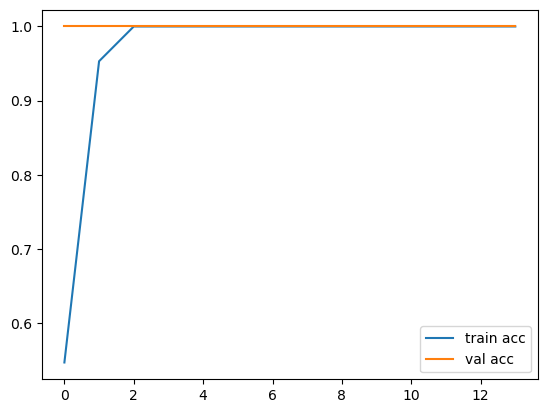

In [26]:
plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

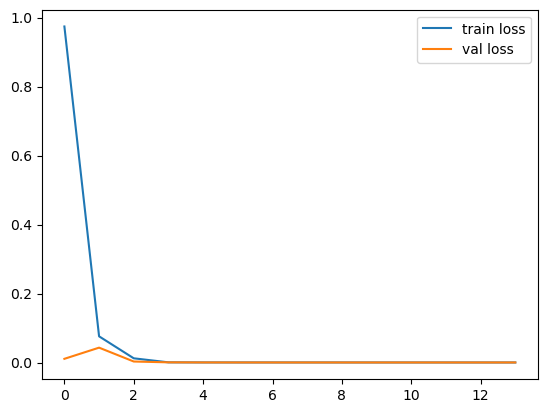

In [35]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [36]:
classification.evaluate(test_x,test_y,batch_size=32)

1/1 [==============================] - 3s 3s/step - loss: 0.0016 - accuracy: 1.0000


[0.0016215526266023517, 1.0]

In [37]:
#predict
y_pred=model.predict(test_x[:1000])
y_pred=np.argmax(y_pred,axis=1)

1/1 [==============================] - 3s 3s/step


In [38]:
import tensorflow as tf
model = tf.keras.models.load_model('classification.h5', compile=False)

In [ ]:
path='/media/al-geddawy/FoE/Muhammad/University/Academics/Year 4/Fall/MTE 438  AI in Mechatronics and Robotics/Final Project/Classification/predict/images'
i=0

for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    if pred[0][0]<0.5:
        category="potato"
        print(category)
    elif pred[0][0]>0.5:
        category="onion"
        print(category)
 
        
    print(category)   
